In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import requests
import json

def pass_web(team,ssn,web): 
    
    ### the 'team' parameter takes in an nba team's three letter abbreviation. 'GSW' for the golden state warriors, for example
    ### the 'ssn' parameter takes in an nba season (2013-14 at the earliest). '2015-16' for example
    ### the 'web' parameter takes in 'AST' or 'pass' (or other variations of the two). 
    ### the 'web' parameter exists because you can create networks in which the lines represent either assists or passes -- the parameter is used to tell which one of the two you'd like to do
    ### example of usage: pass_web('GSW','2016-17','AST')
    
    if (web in ['ast','AST','assist','assists','assisting','ASSIST','ASSISTS']):
        web = 'assist'
    elif (web in ['pass','passes','passing','PASS','PASSES']):
        web = 'pass'
    else:
        return print('Error: Third parameter requires "assist" or "pass" input')
    
    headers = {'Host': 'stats.nba.com','Accept': 'application/json, text/plain, */*','x-nba-stats-token': 'true','User-Agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Mobile Safari/537.36','x-nba-stats-origin': 'stats','Origin': 'https://www.nba.com','Referer': 'https://www.nba.com/','Accept-Encoding': 'gzip, deflate, br','Accept-Language': 'en-US,en;q=0.9}'}
    ### scrape stats.nba.com to find the team_id for the inputted team 
    
    url = 'https://stats.nba.com/stats/leaguedashptstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PerMode=PerGame&Period=0&PlayerExperience=&PlayerOrTeam=Team&PlayerPosition=&PtMeasureType=Drives&Season=' + str(ssn) + '&SeasonSegment=&SeasonType=Regular+Season&StarterBench=&TeamID=0&VsConference=&VsDivision=&Weight='

    json = requests.get(url, headers=headers).json()

    data = json['resultSets'][0]['rowSet']
    columns = json['resultSets'][0]['headers']

    tms = pd.DataFrame.from_records(data, columns=columns)

    team_id = tms[tms.TEAM_ABBREVIATION == team].reset_index(drop=True).TEAM_ID[0]
    team_name = tms[tms.TEAM_ABBREVIATION == team].reset_index(drop=True).TEAM_NAME[0]
    
    ### using the scraped team_id, find all players who accumulated at least 10 assists with that team in the inputted season

    url = 'https://stats.nba.com/stats/leaguedashplayerstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=Totals&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=' + str(ssn) + '&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=' + str(team_id) + '&TwoWay=0&VsConference=&VsDivision=&Weight='

    json = requests.get(url, headers=headers).json()

    data = json['resultSets'][0]['rowSet']
    columns = json['resultSets'][0]['headers']

    df = pd.DataFrame.from_records(data, columns=columns)
    
    df = df[df.AST > 50]

    players = df.PLAYER_ID.unique()
    
    ### using the players previously found, record all of their pass connections while on the team

    df_list = []

    for x in players:

        url = 'https://stats.nba.com/stats/playerdashptpass?DateFrom=&DateTo=&GameSegment=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PerMode=Totals&Period=0&PlayerID=' + str(x) + '&Season=' + str(ssn) + '&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision='

        json = requests.get(url, headers=headers).json()

        data = json['resultSets'][0]['rowSet']
        columns = json['resultSets'][0]['headers']

        df_list.append(pd.DataFrame.from_records(data, columns=columns))

    df = pd.concat(df_list)

    df = df[['TEAM_ABBREVIATION','PLAYER_NAME_LAST_FIRST','PASS_TO','PASS','AST']]
    df.columns = ['tm','passer','receiver','passes','ast']
    
    ### clean up the format for the name

    def fix_name(name):
        if ',' in name:
            return name.split(", ")[1][:1] + "." + name.split(", ")[0]
        else:
            return name
    df.passer = np.vectorize(fix_name)(df.passer)
    df.receiver = np.vectorize(fix_name)(df.receiver)

    df = df[df.receiver.isin(df.passer.unique())].reset_index(drop=True)

    players = df.passer.unique()
    
    ### making list with assist totals for each player (will be used as input for node size)
    
    ast_list = []
    for x in players:
        tf = df[df.passer == x].reset_index(drop=True)
        ast_list.append(tf.ast.sum())
        
    ### creating adjacency matrix

    adf = pd.DataFrame(index=players,columns=players)

    adf.values[[np.arange(adf.shape[0])]*2] = 0
    
    if web == 'pass':
        for x in players:
            for y in range(0,len(players)):
                tf1 = df[(df.passer == x) & (df.receiver == adf.columns[y])].reset_index(drop=True)
                tf2 = df[(df.passer == adf.columns[y]) & (df.receiver == x)].reset_index(drop=True)
                if (tf1.shape[0] == 1) & (tf2.shape[0] == 0):
                    adf.at[x,adf.columns[y]] = tf1.passes[0]
                elif (tf1.shape[0] == 0) & (tf2.shape[0] == 1):
                    adf.at[x,adf.columns[y]] = tf2.passes[0]
                elif (tf1.shape[0] == 1) & (tf2.shape[0] == 1):
                    adf.at[x,adf.columns[y]] = tf1.passes[0] + tf2.passes[0]
                else:
                    adf.at[x,adf.columns[y]] = 0
                    
    else:
        for x in players:
            for y in range(0,len(players)):
                tf1 = df[(df.passer == x) & (df.receiver == adf.columns[y])].reset_index(drop=True)
                tf2 = df[(df.passer == adf.columns[y]) & (df.receiver == x)].reset_index(drop=True)
                if (tf1.shape[0] == 1) & (tf2.shape[0] == 0):
                    adf.at[x,adf.columns[y]] = tf1.ast[0]
                elif (tf1.shape[0] == 0) & (tf2.shape[0] == 1):
                    adf.at[x,adf.columns[y]] = tf2.ast[0]
                elif (tf1.shape[0] == 1) & (tf2.shape[0] == 1):
                    adf.at[x,adf.columns[y]] = tf1.ast[0] + tf2.ast[0]
                else:
                    adf.at[x,adf.columns[y]] = 0
                    
    ### graphing the network
    
    plt.figure(figsize=(8,8))

    G = nx.from_numpy_matrix(np.array(adf.values, dtype=int), parallel_edges=True)
    
    d = dict(G.degree)

    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

    pos = nx.circular_layout(G)
    
    labeldict = {}
    for n in range(0,len(adf.index)):
        labeldict[n] = adf.index[n]

    # nx.draw_circular(G,labels=labeldict,with_labels=True, nodelist=d.keys(), node_size=[v for v in ast_list],linewidths=2, edgelist=edges, edge_color=weights, width=2, edge_cmap=plt.cm.binary, node_color='white')
    nx.draw_circular(G, nodelist=d.keys(), node_size=[v for v in ast_list],linewidths=2, edgelist=edges, edge_color=weights, width=2, edge_cmap=plt.cm.binary, node_color='white')
    
    for p in pos.keys():
        cord = pos[p]
        offset_x, offset_y = 0.12, 0.12
        if (cord[0] < 0):
            offset_x *= -1
        if (cord[1] < 0):
            offset_y *= -1
        cord[0] += offset_x
        cord[1] += offset_y

        pos[p] = cord
    nx.draw_networkx_labels(G, pos, labels=labeldict, horizontalalignment='center')
    
    ax = plt.gca()
    ax.collections[0].set_edgecolor("#000000") 
    
    if web == 'pass':
        plt.title(ssn + ' ' + team_name + ' Passing Network')
    else:
        plt.title(ssn + ' ' + team_name + ' Assist Network')

    yr = ssn[:2] + ssn[5:] # converts '2016-17' to '2017', for instance 
    plt.savefig(team + yr + web  + '.svg',dpi=300,bbox_inches='tight')

C:\Users\User\AppData\Local\Temp\ipykernel_3288\3678259492.py:98: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  adf.values[[np.arange(adf.shape[0])]*2] = 0


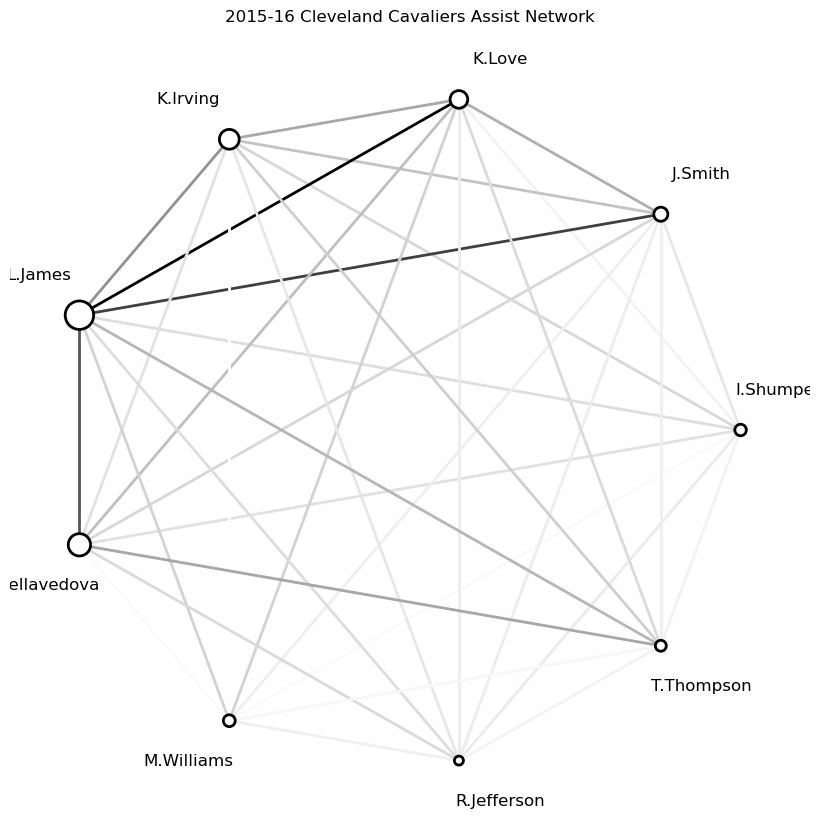

In [16]:
pass_web('CLE','2015-16','AST')

C:\Users\User\AppData\Local\Temp\ipykernel_3288\3678259492.py:98: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  adf.values[[np.arange(adf.shape[0])]*2] = 0


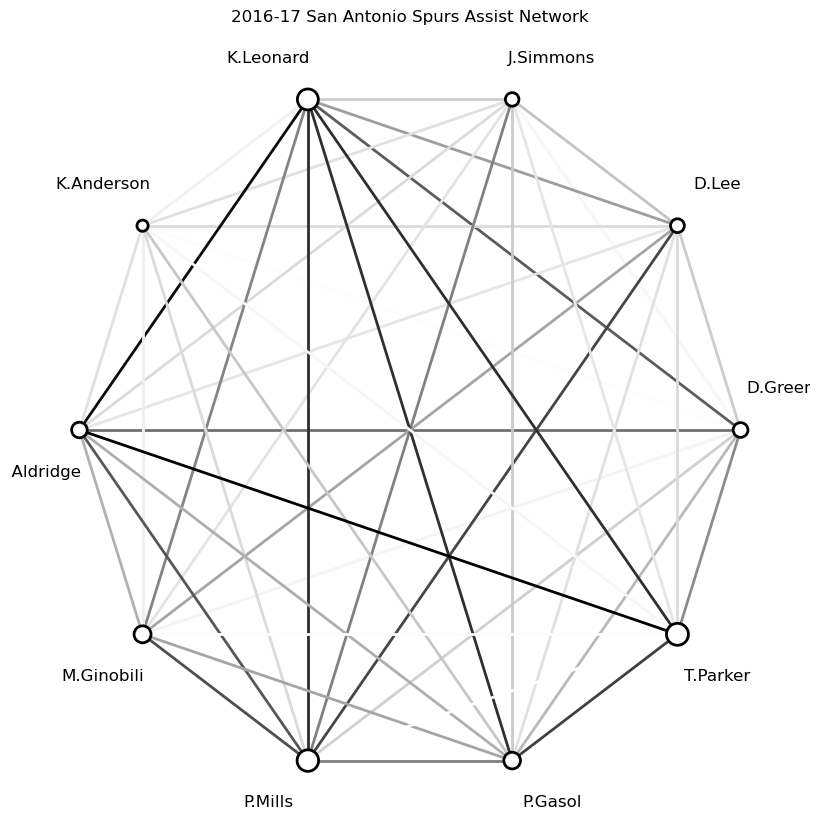

In [3]:
pass_web('SAS','2016-17','AST')

C:\Users\User\AppData\Local\Temp\ipykernel_3288\3678259492.py:98: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  adf.values[[np.arange(adf.shape[0])]*2] = 0


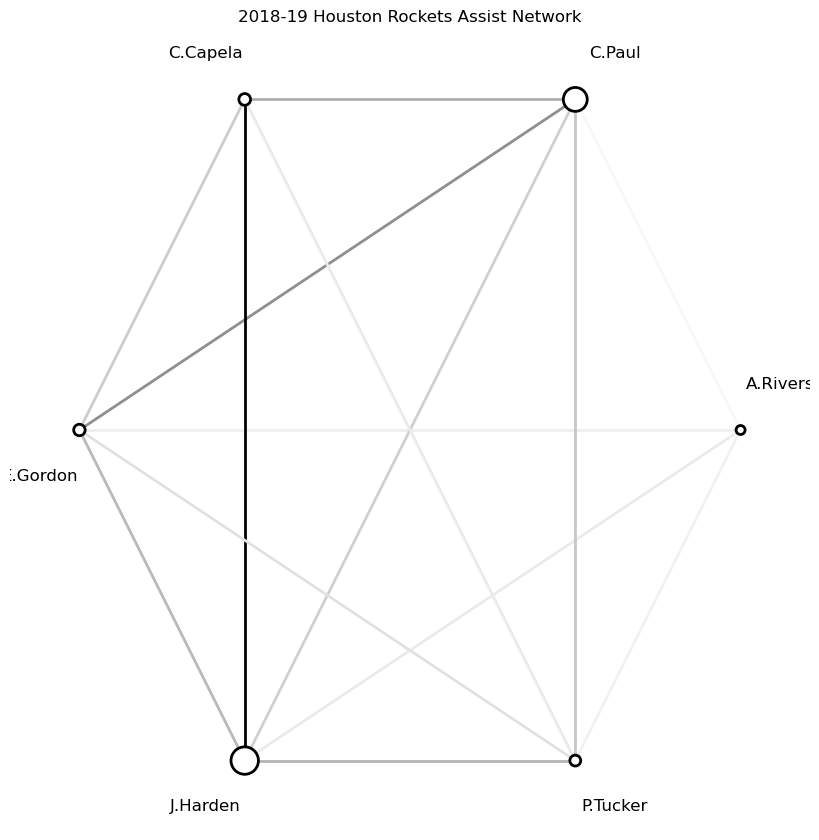

In [4]:
pass_web('HOU','2018-19','AST')

C:\Users\User\AppData\Local\Temp\ipykernel_3288\3678259492.py:98: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  adf.values[[np.arange(adf.shape[0])]*2] = 0


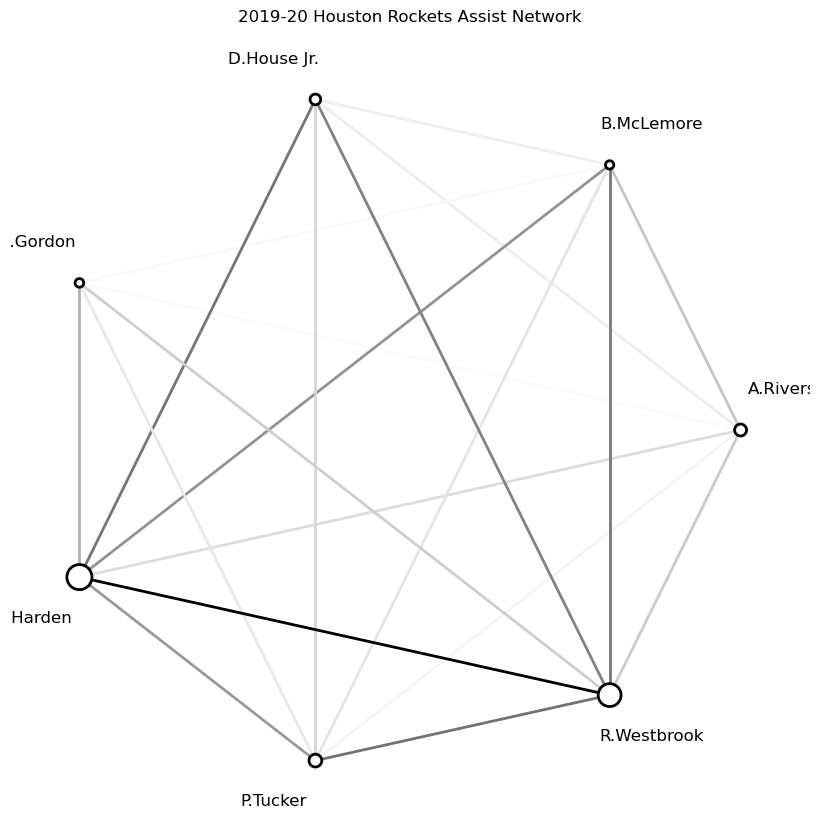

In [5]:
pass_web('HOU','2019-20','AST')

C:\Users\User\AppData\Local\Temp\ipykernel_23752\3678259492.py:98: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  adf.values[[np.arange(adf.shape[0])]*2] = 0


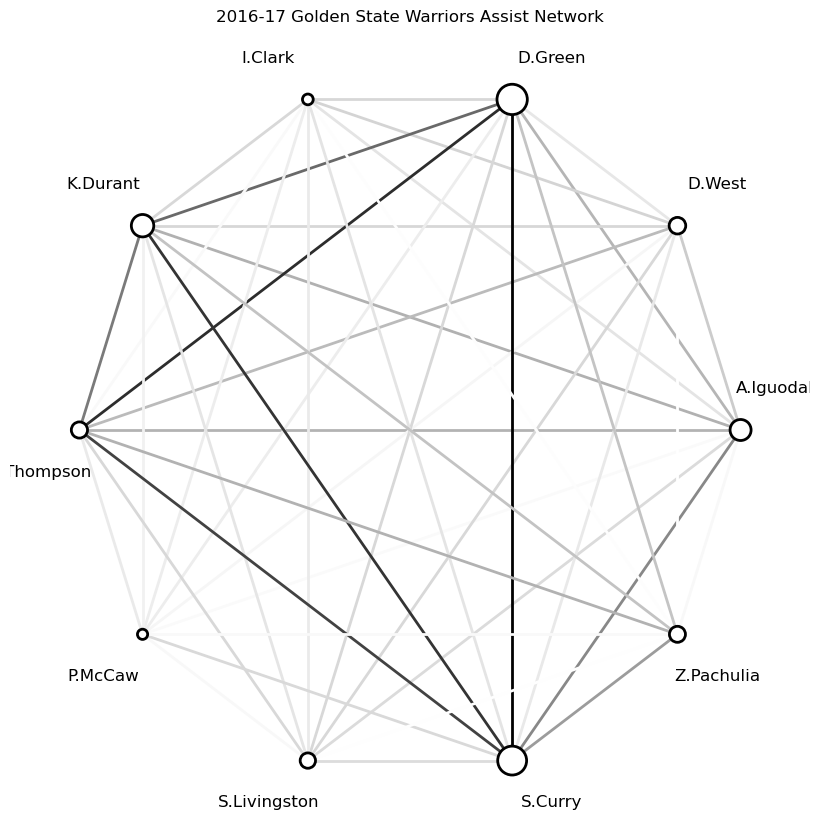

In [3]:
pass_web('GSW','2016-17','AST')

C:\Users\User\AppData\Local\Temp\ipykernel_23752\3678259492.py:98: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  adf.values[[np.arange(adf.shape[0])]*2] = 0


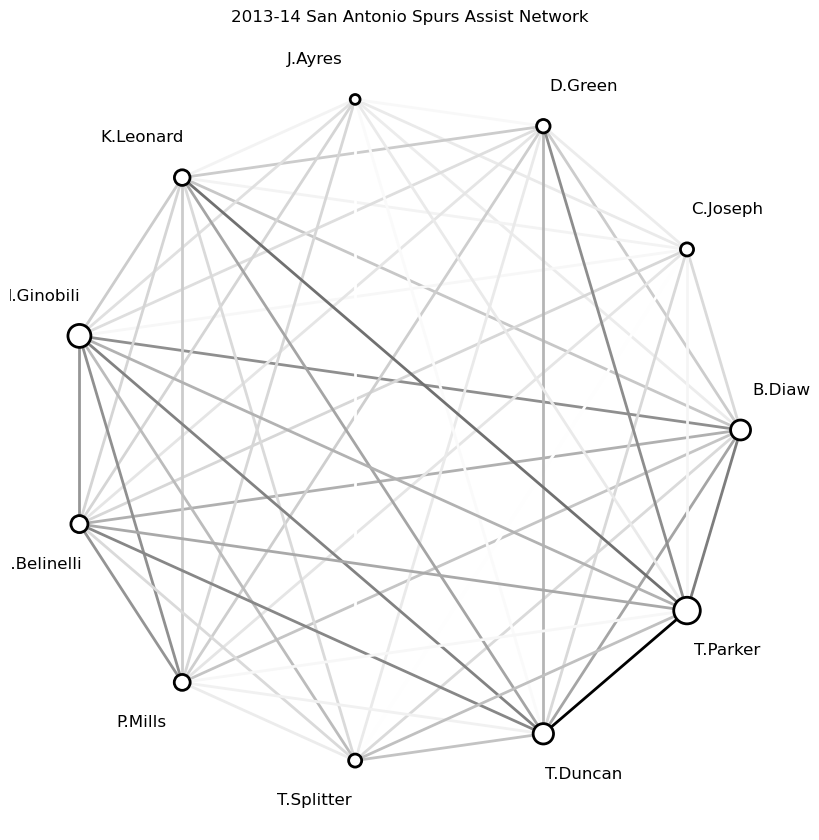

In [5]:
pass_web('SAS','2013-14','AST')

C:\Users\User\AppData\Local\Temp\ipykernel_23752\3678259492.py:98: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  adf.values[[np.arange(adf.shape[0])]*2] = 0


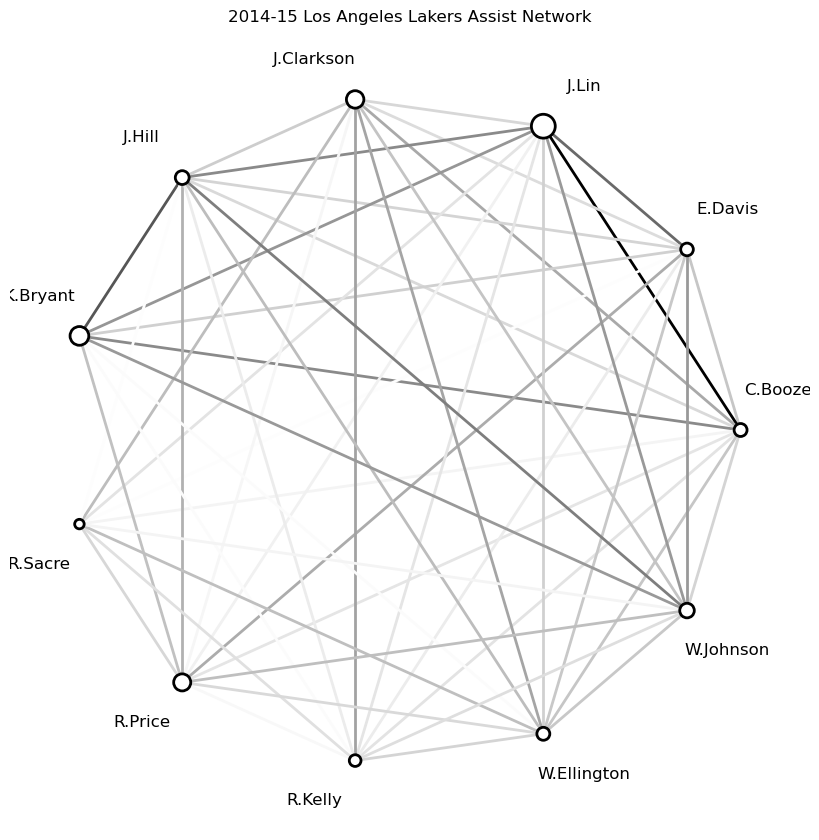

In [10]:
pass_web('LAL','2014-15','AST')